# Handout #2: Introduction to Neural Nets - A Second Example

Content Authors:


*   Chris Malone Ph D, Professor of Data Science and Statistics, Winona State University; Email: cmalone@winona.edu
*   Collin Engstrom PhD, Assistant Professor of Computer Science, Winona State University; Email: collin.engstrom@winona.edu

For this workshop, Handout #2 is a continuation of Handout #1 which can be viewed [here](https://https://drive.google.com/file/d/1YW1yEFpOPXh3XIgN3OHV7Kna-DrHULea/view?usp=sharing).

## Libraries and Custom Functions

The following Python libraries will be used throughout this handout.

In [218]:
# Load Numpy, MatPlot, Pandas, and Seaborn libraries for data processing and graphing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas.plotting import scatter_matrix
import seaborn as sns

# Load TensorFlow and Keres libraries to facilitate fitting of neural net
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Sci-Kit Learn Libraries to faciliate model fitting, metrics,
#from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.utils import resample

print('Tensorflow Version:' + tf.__version__)

Tensorflow Version:2.17.1


The following are custom functions that will be used in this handout.

In [219]:
# Need a function that plots a confusion matrix for us
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [220]:
#ROC Curve
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.1,1.1])
  plt.ylim([0,1.1])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Example #2: Titantic Survival Dataset

<table width='100%' ><tr><td bgcolor='green'></td></tr></table>

The Titantic Surival dataset is another commonly used dataset when learning about the various machine learning algorithms.  This data has one binary Class variable and 6 feautures.

<table>
  <tr>
    <td width='100%'>
      <ul>
        <li><strong>Survivied</strong>: Labels are 0 (Died) and 1 (Survived)</li><br>
        <li><strong>Features</strong>:</li>
        <ul>
          <li>PassengerClass - the type of passenger ticket bought - levels include 1st, 2nd, or 3rd class</li>
          <li>Name - the passenger's name (this feature will be excluded from consideration)</li>
          <li>Sex - the sex of the passenger - levels include Female and Male</li>
          <li>Age - the age of the passenger (years)</li>
          <li>SiblingsSpouseAboard - the number of siblings/spouse aboard</li>
          <li>ParentsChildrenAboard - the number of parents/children aboard</li>
          <li>Fare - the fare for the passsenger ticket (lbs)</li>
         </ul>
    </ul>
    </td>
</tr>
</table>

[Data - Local Copy](https://raw.githubusercontent.com/christophermalone/mayo_ml_workshop/refs/heads/main/Titantic_Survival.csv)

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1693knwy-vhKfEz9KmKrmmSYSWsvdcYga" width='50%' height='50%'></img></p>



Image Source: https://commons.wikimedia.org/wiki/Category:Titanic_%28ship,_1912%29
<table width='100%' ><tr><td bgcolor='green'></td></tr></table>


The following code will read in the Titantic Survival dataset.

In [221]:
url= 'https://raw.githubusercontent.com/christophermalone/mayo_ml_workshop/refs/heads/main/datasets/Titantic_Survival.csv'
Titantic_DF = pd.read_csv(url)

In [222]:
# @title Reading Data from Original Source

#Note: All lines commented out as local copy has been provided
#url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'
#Titantic_DF = pd.read_csv(url, header=0).replace('?', np.nan).dropna()

#Note: Some of the feature names in the original dataset are slightly different than the local copy.

Taking a look at the Titantic Survival dataset.

In [223]:
Titantic_DF.head()
#Titantic_DF.shape
#Titantic_DF.dtypes


,Survived,PassengerClass,Name,Sex,Age,SiblingsSpousesAboard,ParentsChildrenAboard,Fare
0,0,3,Mr. Owen Harris Braund,Male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,Female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,Female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,Female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,Male,35.0,0,0,8.0500


## Investigating the Class variable

Consider the following counts of those that Died (Survived = 0) and those that Survived (Survived = 1)

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1XXEtym5a3Zrhr2_ub6n45HgObiXatfNP" width='40%' height='40%'></img></p>

The following code can be used to compute the balance of the Class variable.

In [224]:
# Find class balance
neg, pos = np.bincount(Titantic_DF['Survived'])
total = neg + pos
print('Samples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Samples:
    Total: 887
    Positive: 342 (38.56% of total)



## Fixing the Imbalance in the Class Variable

### What is Upsampling

The Class variable for this classification problem is Survived.  The labels for the class variable are not balanced and the concept of **upsampling** can be used to address this issue. Upsampling is a data processing technique that adds synthetic data to the training set for the minority class label.  Upsampling should only be done to the training set as the test set should mimic the intended population as much as possible.


The following steps will be used to perform upsampling in the Training set.

1.   Partition the cases into a Training set and a Test set
2.   Identify the minority label in the Training set
3.   Upsample the minority label in the Training set so that the binary labels are balanced



<p align='center'><img src="https://drive.google.com/uc?export=view&id=134HF0S8YIsc695EVWozjyO3LL36BR8RK" width='35%' height='35%'></img></p>

After the training and test sets have been established, the next step is to identify the distribution of labels in the training set.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1p3UUk24-Kxrudj5OuwaXcSAu-2LJ2FYc" width='50%' height='50%'></img></p>



Upsampling involves creating additional cases for the minority class so that the labels in the training set become balanced.  Upsampling is not done to the Test set as the Test set should mimic the target population.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1vT1y2AlKfSQyZeXYUVxepRz2MfE67Py3" width='50%' height='50%'></img></p>


For the sake of discussion, consider a Training set where the Survived = 0 label had $10$ observations and the Survived = 1 label only had $7$ observations.  Consider the following schematic that depicts this situation.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1eaTicgepzkeGfhhHP1ifp0BCTFePbYmA" width='100%' height='100%'></img></p>


One of the simpliest approaches to doing upsampling is to simply replicate $3$ of the passengers from the Survived = 1 group.  The schematic below shows that passengers #2, #4, and #6 were replicated and have appended to the bottom of the Surivived = 1 dataset.  The two labels will now be balanced in the training set.

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1sr9vACC_ADUrN_TMCN6JQARkMrEpOZEe" width='100%' height='100%'></img></p>


### Implementation of Upsampling

Step 1: Partition the passengers into a Training and Test set.

The following code will partition the data into a training set and a test set.  Here at $70:30$ split will be used.

In [225]:
# Create a Train and Test set of the data
Titantic_DF_Train, Titantic_DF_Test = train_test_split(Titantic_DF,
                                                       test_size=0.30,
                                                       shuffle=True)

Step 2: Identify the minorty label in the Training set

In [226]:
# Find class balance
neg_train, pos_train = np.bincount(Titantic_DF_Train['Survived'])
total_train = neg_train + pos_train
print('Samples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_train, pos_train, 100 * pos_train / total_train))

Samples:
    Total: 620
    Positive: 243 (39.19% of total)



Step 3: Upsample the minority label in the Training set

In the situation presented here, the minority label is the positive cases (i.e. passengers that survivied).  Thus, upsampling will be done on the positive cases.

In [227]:
# Obtain a data.frame that contains only the Survived = 1 rows in the Training set
Titantic_DF_Train_Positive = Titantic_DF_Train.loc[Titantic_DF_Train['Survived'] == 1]

print(Titantic_DF_Train_Positive.shape)
#Titantic_DF_Train_Positive.head()

(243, 8)


The **resample()** function from the skikitlearn utilites package will be used to resample rows from the desired desired data.frame.

In [228]:
# Upsample minority class in the training set
Titantic_DF_Train_Positive_Upsample = resample(Titantic_DF_Train_Positive,
                                                replace=True,
                                                n_samples=(neg_train-pos_train),
                                                random_state=42348342)

print('A total of', len(Titantic_DF_Train_Positive_Upsample), 'cases were resampled')

A total of 134 cases were resampled


Next, the synthetic data that was created by the upsampling method will be appended into the Training data.frame.

In [229]:
Titantic_DF_Train_Balanced = pd.concat([Titantic_DF_Train, Titantic_DF_Train_Positive_Upsample])

A quick check to make sure the labels are balanced in the training data.

In [230]:
# Find class balance of upsampled training set
neg_train_balanced, pos_train_balanced = np.bincount(Titantic_DF_Train_Balanced['Survived'])
total_train_balanced = neg_train_balanced + pos_train_balanced
print('Samples in the Training Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_train_balanced, pos_train_balanced, 100 * pos_train_balanced / total_train_balanced))

Samples in the Training Set:
    Total: 754
    Positive: 377 (50.00% of total)



Notice that the imbalance of the labels remains in the test set which is desired.

In [231]:
# Find class balance of upsampled test set
neg_test_set, pos_test_set = np.bincount(Titantic_DF_Test['Survived'])
total_test_set = neg_test_set + pos_test_set
print('Samples in the Test Set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_test_set, pos_test_set, 100 * pos_test_set / total_test_set))

Samples in the Test Set:
    Total: 267
    Positive: 99 (37.08% of total)



The following code will reset the indices of the training and test data.frames.

In [232]:
# Reset indices
Titantic_DF_Train_Balanced = Titantic_DF_Train_Balanced.reset_index(drop=True)
Titantic_DF_Test = Titantic_DF_Test.reset_index(drop=True)

## Data Preprocessing

In this handout, upsampling required the data to be partitioned into a Training set and a Test set.  Thus, the following notation will be used here.

*   $\bf{X}_{Train}$ represents the features in the Training set and $\bf{y}_{Train}$ represents the class variable in the Training set
*   $\bf{X}_{Test}$ represents the features in the Test set and $\bf{y}_{Test}$ represents the class variable in the Test set




The fitting of a nueral net requires that the features and class variable must be seperated into two pieces, i.e.  $\bf{X}_{Train}$ and $\bf{y}_{Train}$.  The Name feature will be excluded from both $\bf{X}_{Train}$ and $\bf{X}_{Test}$ .

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1ZSuXU2zLYX4vuXPkJtBLSUiyk2bJrEL2" width='50%' height='50%'></img></p>



The following code will be used to get the $\bf{X}_{Train}$ matrix.

In [233]:
#Getting the Features matrix for the training set
X_Train_DF = Titantic_DF_Train_Balanced.drop(['Survived','Name'], axis=1)
X_Train_DF[0:10]

,PassengerClass,Sex,Age,SiblingsSpousesAboard,ParentsChildrenAboard,Fare
0,3,Male,29.0,0,0,7.8750
1,1,Female,31.0,0,2,164.8667
2,3,Male,22.0,0,0,7.1250
3,1,Female,24.0,0,0,49.5042
4,3,Male,18.0,0,0,7.2250
5,3,Male,18.0,0,0,7.2500
6,1,Male,24.0,0,0,79.2000
7,3,Male,42.0,0,0,7.8958
8,3,Male,4.0,1,1,15.2458
9,3,Female,19.0,1,0,7.8542


### Scaling the Numerical Features

Recall, the neural net algorithm requires the calculation of many weighted linear cominbations of the features.  In order for the algorithm to work, the $\bf{X}_{Train}$ matrix will need to contain only numerical values.  Furthermore, the features should be properly scaled so that one feature does not dominant the weighted linear combinations.

First, let us get a statistical summary of the numerical features in $\bf{X}_{Train}$.

In [234]:
#Get a statistical summary of each numerical feature in the X
Titantic_DF_Train_Balanced.drop(['Survived','PassengerClass','Name', 'Sex'], axis=1).describe()

,Age,SiblingsSpousesAboard,ParentsChildrenAboard,Fare
count,754.000000,754.000000,754.000000,754.000000
mean,29.067639,0.500000,0.391247,33.097668
std,14.011092,0.988983,0.786323,48.140832
min,0.420000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,8.050000
50%,28.000000,0.000000,0.000000,15.500000
75%,36.875000,1.000000,1.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


Notice that the scales of these features are very different.  A $MinMaxScaler$ transformation will be used to scale these features so that all values are between $0$ and $1$, i.e. $[0,1]$.

### Encoding the Categorical Features

Notice that the $Sex$ feature in $\bf{X}$ is a categorical variable.  **OneHotEncoding** will be used be used to transform the $Sex$ feature so that this information can be used by the nueral net.  OneHot encoding simply uses a binary representation of $Sex$ which is shown below. Notice that the Sex-F column is redundant as only one column is needed to represent a binary outcome.

Let us next consider the $PassengerClass$ feature. The $PassengerClass$ feature does have labels that are represented by numbers (i.e. $1$, $2$, and $3$), but these numbers simply represent three distinct groups of passengers.  For this reason, a OneHot encoding tranformation will be used on $PassengerClass$ as well.  $PassengerClass$ has three distinct values which implies two variables are needed to represent the information contained in $PassengerClass$.

The OneHot encoding tranformation will initially produce an array with 3 elements, i.e. [PassengerClass1, PassengerClass2, and PassengerClass3]. A first class passenger would be represented by [1,0,0], a second class passenger would be represened by [0,1,0] and a third class passenger would be represened by [0,0,1].  Realize, an array with only 2 elements, i.e. [PassengerClass2, PassengerClass3] can be used to represent the same information.  A first class passenger would be represented by [0,0] in this array, a second class passenger would be represented by [1,0], and a third class passenger would be represented by [0,1].

<p align='center'><img src="https://drive.google.com/uc?export=view&id=1vQlBmlHc5ZhGFKeM6w-TaoLnvIMXwF3R" width='80%' height='80%'></img></p>

The following code specifies the type of transformation that will be done on the various features contained in $\bf{X}_{Train}$.   The $drop='first'$ specification for the OneHotEncoder will drop the first element of the array returned by the OneHotEncoder transformation.

In [235]:
transformers_list = [
                      ('encode', OneHotEncoder(dtype='int',drop='first'),['PassengerClass','Sex']),
                      ('scale', MinMaxScaler(), ['Age', 'SiblingsSpousesAboard', 'ParentsChildrenAboard', 'Fare'])
                    ]

column_transformer = ColumnTransformer(transformers_list)

Next, apply the desired transformations to $\bf{X}_{Train}$.

In [236]:
#Apply the desired tranformation to the matrix of features
X_Train = column_transformer.fit_transform(X_Train_DF)
X_Train[0:10]

array([[0.        , 1.        , 1.        , 0.35913546, 0.        ,
        0.        , 0.01537098],
       [0.        , 0.        , 0.        , 0.3842674 , 0.        ,
        0.4       , 0.32179837],
       [0.        , 1.        , 1.        , 0.27117366, 0.        ,
        0.        , 0.01390707],
       [0.        , 0.        , 0.        , 0.2963056 , 0.        ,
        0.        , 0.09662576],
       [0.        , 1.        , 1.        , 0.22090978, 0.        ,
        0.        , 0.01410226],
       [0.        , 1.        , 1.        , 0.22090978, 0.        ,
        0.        , 0.01415106],
       [0.        , 0.        , 1.        , 0.2963056 , 0.        ,
        0.        , 0.1545881 ],
       [0.        , 1.        , 1.        , 0.52249309, 0.        ,
        0.        , 0.01541158],
       [0.        , 1.        , 1.        , 0.04498618, 0.125     ,
        0.2       , 0.02975782],
       [0.        , 1.        , 0.        , 0.23347575, 0.125     ,
        0.        , 0.0

Obtain a quick statistical summary of all the features to ensure each is between $0$ and $1$.

In [237]:
#Getting a quick summary to ensure all features are properly scaled between 0 and 1
DataFrame(X_Train).describe()

,0,1,2,3,4,5,6
count,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000,754.000000
mean,0.210875,0.513263,0.599469,0.359985,0.062500,0.078249,0.064602
std,0.408201,0.500156,0.490331,0.176063,0.123623,0.157265,0.093965
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.246042,0.000000,0.000000,0.015713
50%,0.000000,1.000000,1.000000,0.346569,0.000000,0.000000,0.030254
75%,0.000000,1.000000,1.000000,0.458092,0.125000,0.200000,0.061264
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The following code will create the $\bf{y}_{Train}$ vector for the cases in the Training set.

In [238]:
#Geting the class varable for the nueral net
y_Train = Titantic_DF_Train_Balanced['Survived'].to_numpy()
y_Train[0:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1])

In [239]:
# ensure the labels have been encoded to be integers
y_Train = LabelEncoder().fit_transform(y_Train)

### Replicate Data Processing for the Test Set

The data processing steps will need to be repeated with the Test set. The process described above will need to be done for $\bf{X}_{Test}$ and $\bf{y}_{Test}$.

In [240]:
#Getting the Features matrix for the test set
X_Test_DF = Titantic_DF_Test.drop(['Survived','Name'], axis=1)

Apply the ColumnTransformer to the feature matrix from the test set.

In [241]:
X_Test = column_transformer.fit_transform(X_Test_DF)

Finally, obtain $\bf{y}$ from the test set.

In [242]:
#Geting the class varable for test set
y_Test = Titantic_DF_Test['Survived'].to_numpy()

## Fitting the Neural Net

The number of features in $\bf{X}$ will be needed in the model specification step.

In [243]:
# determine the number of input features
n_features = X_Train.shape[1]
print(n_features)

7


The following model specification will be used for the nueral net.

In [244]:
# Initiate the model
model = Sequential()

# Three layers each with 8 , respectively
model.add(Dense(8, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(8, activation='relu', kernel_initializer='he_normal'))


# Last layer will be one node and output a probability value in the range [0,1]
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The following complier specification will be used for the nueral net.

In [245]:
# Specification of the compiler for the nueraul network model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['auc','accuracy'])

The following specifications will be used for fitting the model.

In [246]:
# fit the model
model.fit(X_Train, y_Train, epochs=50, batch_size=32, verbose=0)

## Making Predictions

The model.predict() object will be used to make predictions using your model. Recall, model performance should be evaluated on the *test* dataset; thus, the features from the *test* dataset are passed into model.predict in this code.

In [247]:
# Getting predictions for the features in the test set
Predictions_Test = model.predict(X_Test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step




---



## Model Performance

The following code can be be used to compute $Accuracy$ and $Area \, Under \, ROC$.  Model performance metrics should be computed on the *test* set.  Here, these metrics will also be computed on the *training* set as well for purposes of discussion.

In [248]:
# Using model.evaluate to obtain acc and auc
losstrain, acctrain, auctrain  = model.evaluate(X_Train, y_Train, verbose=0)
losstest, acctest, auctest  = model.evaluate(X_Test, y_Test, verbose=0)

print('Model Accuracy (Train): %.3f' % acctrain)
print('Model Accuracy (Test): %.3f' % acctest)
print('')

print('Area Under Curve (Train): %.3f' % auctrain)
print('Area Under Curve (Test): %.3f' % auctest)


Model Accuracy (Train): 0.836
Model Accuracy (Test): 0.806

Area Under Curve (Train): 0.772
Area Under Curve (Test): 0.753


Notice that the performance of the predictive model is better for the *training* set than the *test* set.  This should be expected as the predictive model was built using the *training* set.  One indication that a predictive model is overfitting is a large discrepancy in the $Accuracy$ from the *training* to the *test* sets.

The $ROC$ plot is provided below.

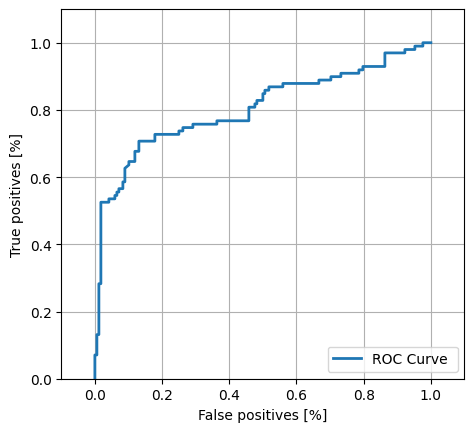

In [249]:
# Do an ROC curve
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("ROC Curve ", y_Test, Predictions_Test, color=colors[0])
plt.legend(loc='lower right');

The confusion matrix for the data from the *test* set is provided below.  The custom plot_cm() function allows for specification of the threshold in the determining the predicted labels for the class variable.

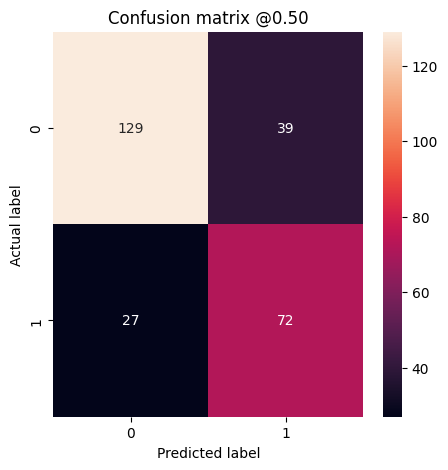

In [250]:
plot_cm(y_Test, Predictions_Test, threshold = 0.50)



---



---


The End...

